In [76]:
# importing Required Libraries and Load Data set

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [77]:
# importing the data set
try:
    df = pd.read_csv("Raw_Data/train.csv")
except:
    df = pd.read_csv("train.csv")

# display the first five row of the dataframe
df.head()


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [78]:
# data preprocessing and feature engineering
# defining the target variable and feature set

target = "accident_risk"


In [79]:
# separate x and y

X = df.drop(columns=[target])
y = df[target]



In [80]:
numerical_features = [
    "num_lanes",
    "curvature",
    "speed_limit",
    "num_reported_accidents"
]

categorical_features = [
    "road_type",
    "lighting",
    "weather",
    "time_of_day"
]

boolean_features = [
    "road_signs_present",
    "public_road",
    "holiday",
    "school_season"
]

id_column = "id"

In [81]:
# handling the id columns since it is important for the submission.csv file
X_ids = X[id_column]
X = X.drop(columns=[id_column])

In [82]:
# dealing with boolean ctegories
# converting boolean features to intergers as 0 and 1 represent False and True respectively
X[boolean_features] = X[boolean_features].astype(int)

🧾 Preprocessing Summary (Notebook-Ready)

“After EDA, preprocessing involved separating the target variable, excluding identifiers from training features, converting boolean flags to numeric format, and explicitly categorizing numerical and categorical variables. A train–validation split was applied to support robust model evaluation while preserving Kaggle submission requirements.”

In [83]:
df["speed_risk_band"] = pd.cut(
    df["speed_limit"],
    bins=[0, 30, 50, 70, 100],
    labels=["very_low", "low", "medium", "high"]
)


In [84]:
df["speed_risk_band"].value_counts()


speed_risk_band
low         227380
medium      188952
very_low    101422
high             0
Name: count, dtype: int64

In [85]:
df["high_curvature"] = (df["curvature"] > 0.6).astype(int)

In [86]:
df["lane_complexity"] = df["num_lanes"] * df["curvature"]

In [87]:
df["accident_density"] = df['num_reported_accidents'] / (df['num_lanes'] + 1)


In [88]:
df["poor_visibility"] = df["weather"].isin(["fog", "rain"]).astype(int)


In [89]:
numerical_features = [
    "num_lanes",
    "curvature",
    "speed_limit",
    "lane_complexity"      # SAFE
]

categorical_features = [
    "road_type",
    "lighting",
    "weather",
    "time_of_day",
    "speed_risk_band"      # SAFE engineered category
]


boolean_features = [
    "road_signs_present",
    "public_road",
    "holiday",
    "school_season",
    "high_curvature",      # SAFE
    "poor_visibility"      # SAFE
]



In [90]:
df[["num_reported_accidents", "num_lanes", "accident_density"]].head()


,num_reported_accidents,num_lanes,accident_density
0,1,2,0.333333
1,0,4,0.000000
2,2,4,0.400000
3,1,4,0.200000
4,1,1,0.500000


In [91]:
df[["num_reported_accidents", "accident_risk"]].corr()


,num_reported_accidents,accident_risk
num_reported_accidents,1.000000,0.213891
accident_risk,0.213891,1.000000


In [92]:

features = numerical_features + categorical_features + boolean_features


In [93]:
# preparing training data
x = df[features]
y = df['accident_risk']

In [94]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)



In [95]:
cat_features_idx = [
    X_train.columns.get_loc(col)
    for col in categorical_features
    if col in X_train.columns
]


In [96]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(
    iterations=600,
    learning_rate=0.05,
    depth=8,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=42,
    verbose=100
)


In [97]:
# train catboost
cat_model.fit(
    X_train,
    y_train,
    cat_features=cat_features_idx,
    eval_set=(X_val, y_val),
    use_best_model=True
)


0:	learn: 0.1592976	test: 0.1590170	best: 0.1590170 (0)	total: 1.25s	remaining: 12m 26s
100:	learn: 0.0564315	test: 0.0566909	best: 0.0566909 (100)	total: 48.1s	remaining: 3m 57s
200:	learn: 0.0562491	test: 0.0565518	best: 0.0565518 (200)	total: 1m 28s	remaining: 2m 54s
300:	learn: 0.0561149	test: 0.0564634	best: 0.0564634 (300)	total: 2m 17s	remaining: 2m 16s
400:	learn: 0.0559855	test: 0.0563719	best: 0.0563719 (400)	total: 3m 11s	remaining: 1m 35s
500:	learn: 0.0558937	test: 0.0563242	best: 0.0563242 (500)	total: 4m 4s	remaining: 48.3s
599:	learn: 0.0558183	test: 0.0562941	best: 0.0562941 (598)	total: 4m 48s	remaining: 0us

bestTest = 0.05629405342
bestIteration = 598

Shrink model to first 599 iterations.


In [98]:
# predict a validation set
y_val_pred = cat_model.predict(X_val)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
rmse

np.float64(0.05629405370962316)

In [101]:
#sanity check
y_val_pred.min(), y_val_pred.max()

(np.float64(0.026136709402837077), np.float64(0.8716666564630273))

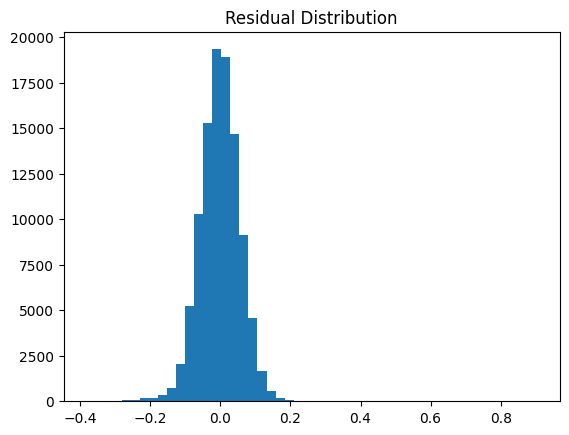

In [ ]:
# residual distribution

residuals = y_val - y_val_pred

plt.hist(residuals, bins=50)
plt.title("Residual Distribution")
plt.show()
